gamma和theta互为机会成本

# Deribit

交易活跃度有限，btc的atm合约大概几分钟一笔。

盘口价差很大，不同交易所的价差也很大。

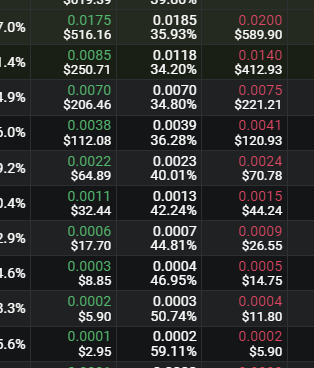

# Calendar spread


收益曲线显示的是在近月的到期后马上将远月的卖出。近月的theta比远月大，因此衰减得快。总体theta为正，挣的是theta。风险是vega。


- **日历价差表达的观点**是：卖近买远或买近卖远。
    
    如果你认为近期价格波动不大但远期价格会变，则可以做日历价差，过了波动不大的近期，将卖出近期部分平掉，留着远期的买方期权等远期波动获利。
    
    如果你认为近期波动大但远期价格不会变，则可以卖出日历价差，等波动大的近期获利了结后，卖出远期期权等坐收权利金。





In [ ]:
import pandas as pd

calendar = pd.read_csv('Table Data-Thu Aug 10 2023.csv')
calendar

In [ ]:
position_810 = pd.read_csv('Positions_810.csv')
position_810

In [ ]:
import tushare as ts
pro = ts.pro_api('36f388934ca1bc35e4adf3533214eea55cc093ec46b6415cb9ca10b0')
data = pro.query('daily', ts_code='000001.SZ', start_date='20200101', end_date='20230718')
data

In [51]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 读取数据
features = ['close','pct_chg']
data = data[features]   # 选择需要预测的列

# 数据预处理
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
seq_length = 10  # 序列长度，可以根据实际情况调整

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, seq_length)

# 划分训练集和测试集
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 构建LSTM模型
model = Sequential()
model.add(LSTM(units=30, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=30, activation='relu'))
model.add(Dense(units=1))  # 预测一个值

model.compile(optimizer='adam', loss='mse')  # 均方误差作为损失函数

# 模型训练

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/30
22/22 [==============================] - 5s 39ms/step - loss: 0.1900 - val_loss: 0.1360
Epoch 2/30
22/22 [==============================] - 0s 15ms/step - loss: 0.0592 - val_loss: 0.0191
Epoch 3/30
22/22 [==============================] - 0s 10ms/step - loss: 0.0232 - val_loss: 0.0144
Epoch 4/30
22/22 [==============================] - 0s 11ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 5/30
22/22 [==============================] - 0s 14ms/step - loss: 0.0119 - val_loss: 0.0127
Epoch 6/30
22/22 [==============================] - 0s 12ms/step - loss: 0.0115 - val_loss: 0.0128
Epoch 7/30
22/22 [==============================] - 0s 10ms/step - loss: 0.0115 - val_loss: 0.0131
Epoch 8/30
22/22 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0128
Epoch 9/30
22/22 [==============================] - 0s 13ms/step - loss: 0.0116 - val_loss: 0.0129
Epoch 10/30
22/22 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0133
Epoch 11/

In [52]:
# 预测
predicted_scaled = model.predict(X_test)
X_test_last_step = X_test[:, -1, :-1]  # Select the last step of the input sequence
X_test_last_step_reshaped = np.hstack((X_test_last_step, np.zeros((X_test_last_step.shape[0], 1))))

# Inverse transform
predicted_combined = np.hstack((X_test_last_step_reshaped, predicted_scaled))
predicted_original_scale = scaler.inverse_transform(predicted_combined)

# 输出预测结果
predictions_df = pd.DataFrame(predicted_original_scale, columns=['close', 'pct_chg'])
predictions_df.to_csv('predictions.csv', index=False)  # 保存预测结果


6/6 [==============================] - 1s 5ms/step


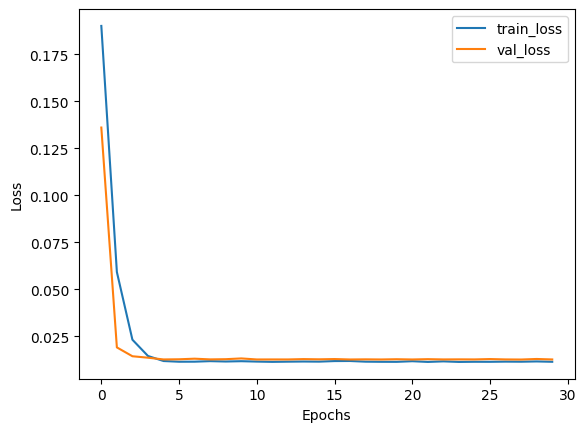

In [53]:

# 绘制损失曲线
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("RMSE:", rmse)
print("MAE:", mae)


6/6 [==============================] - 0s 4ms/step
RMSE: 0.11278083934020348
MAE: 0.08136965308203639
